# Projet 7 : Implémentez un modèle de scoring

"Prêt à dépenser" : propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

### Les missions 
+ Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
+ Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

# Information sur le kernel

Pour la suite de notre étude, nous allons nous appuyer sur le Kernel Kaggle : Start Here: A Gentle Introduction

# Data

Les données sont issues d'un concours organisé sur Kaggle par l'entreprise "Home Credit".

Home Credit est un service dédié à la fourniture de prêts à la population non bancarisée.
Prédire si un client remboursera ou non un prêt ou s'il aura des difficultés est un besoin commercial essentiel,
et Home Credit organise cette compétition sur Kaggle pour voir quel type de modèles la communauté
de l'apprentissage automatique peut développer pour l'aider dans cette tâche.

l y a **7 sources** de données différentes :

+ **application_train/application_test** : les principales données de train et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de train sont accompagnées de la caractéristique TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
Dans ce projet, nous ne participons pas au concours Kaagle, nous n'utiliserons donc pas les données de application_test qui ne contiennent pas la colonne **TARGET**.
Nous n'utiliserons que les données contenues dans **application_train** puis nous spliterons nous même nos données en un jeu de train et un jeu de test.
+ **bureau** : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne < dans bureau, mais un prêt existant dans application_(train|test) peut avoir plusieurs crédits précédents.
+ **bureau_balance** : données mensuelles concernant les crédits précédents dans bureau. Chaque ligne correspond à un mois de crédit précédent, et un crédit précédent unique peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
+ **previous_application** : demandes précédentes de prêts a Home Credit des clients qui ont des prêts dans les données de application_(train|test). Chaque prêt actuel dans les données de application_(train|test) peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
+ **POS_CASH_BALANCE** : données mensuelles sur les prêts au point de vente ou en espèces que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.
+ **credit_card_balance** : données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
+ **installments_payment** : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.


## Métrique utilisée: ROC AUC

Nous allons utiliser la métrique préconisé dans le concour Kaggle : ROC AUC

Il s'agit d'une métrique de classification commune connue sous le nom d'aire sous la courbe de la caractéristique d'exploitation du récepteur (ROC AUC, parfois aussi appelée AUROC).

La ROC AUC peut sembler intimidante, mais elle est relativement simple une fois que vous avez compris les deux concepts individuels:

+ La courbe **ROC** (Reciever Operating Characteristic) est un graphique représentant les performances d'un modèle de classification pour tous les seuils de classification. Cette courbe trace le taux de vrais positifs en fonction du taux de faux positifs
+ L'aire sous la courbe (AUC) s'explique par son nom ! Il s'agit simplement de l'aire sous la courbe ROC. (Il s'agit de l'intégrale de la courbe) Cette métrique est comprise entre 0 et 1, un meilleur modèle obtenant un score plus élevé. Un modèle qui se contente de deviner au hasard aura une AUC ROC de 0,5.

Lorsque nous mesurons un classificateur selon l'AUC ROC,nous ne générons pas des prédictions 0 ou 1, mais plutôt une probabilité entre 0 et 1. Cela peut prêter à confusion car nous aimons généralement penser en termes de précision, mais lorsque nous sommes confrontés à des problèmes de classes déséquilibrées (nous verrons que c'est le cas), la précision n'est pas la meilleure métrique. 
Par exemple, si je voulais construire un modèle capable de détecter les terroristes avec une précision de 99,9999 %, je créerais simplement un modèle qui prédit que chaque personne n'est pas un terroriste. Il est clair que cela ne serait pas efficace (le rappel serait nul) et nous utilisons des mesures plus avancées telles que le ROC AUC
ou le score F1 pour refléter plus précisément les performances d'un classificateur. Un modèle avec un ROC AUC élevé aura également une précision élevée, mais le ROC AUC est une meilleure représentation de la performance du modèle.

# Importation des librairies

In [1]:
import gc
import cufflinks as cf
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

py.init_notebook_mode(connected=True)
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
pip install cufflinks

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import gc
import time
import numpy as np
import pandas as pd
import pickle
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
pd.set_option('display.max_column', 47)
pd.set_option('display.max_row', 22551)

# Les bases de données

Dans un premier temps nous allons lister tous les fichiers de données disponibles, au total 9 fichiers sont présents dans notre coprus 
+ 1 fichier principal pour l'entraînement (avec la cible)
+ 1 fichier principal pour le test (sans la cible)
+ 1 fichier de soumission d'exemples
+ et 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.

In [5]:
print(os.listdir("../credit-default-risk"))

['app_train.csv', 'application_test.csv', '.DS_Store', 'Untitled.ipynb', 'HomeCredit_columns_description.csv', 'X_features.csv', 'POS_CASH_balance.csv', 'Untitled2.ipynb', 'credit_card_balance.csv', 'installments_payments.csv', 'client_information.csv', 'application_train.csv', 'crédit-final_test.ipynb', 'bureau.csv', 'client_information_sample.csv', '.ipynb_checkpoints', 'crédit-final.ipynb', 'previous_application.csv', 'crédit-final-Copy1.ipynb', 'df_final.csv', 'bureau_balance.csv', 'X_poly.csv', 'sample_submission.csv', 'model projet_7.ipynb', 'LGBM.pkl', 'crédit-final-Copy3.ipynb']


In [6]:
def information(dataframe):
    print("{} lignes et {} colonnes".format(dataframe.shape[0],
                                            dataframe.shape[1]))
    print("**"*30)
    print("Informations sur les features : ", dataframe.info())
    print("**"*30)
    print("Le nombre total de valeur manquante : \n", dataframe.isnull().sum())
    print("**"*30)
    print("")
    return dataframe.head(5)

In [7]:
application_test = pd.read_csv('../credit-default-risk/application_test.csv')
application_train = pd.read_csv('../credit-default-risk/application_train.csv')
pos = pd.read_csv('../credit-default-risk/POS_CASH_balance.csv')
cc = pd.read_csv('../credit-default-risk/credit_card_balance.csv')
ins = pd.read_csv('../credit-default-risk/installments_payments.csv')
bureau = pd.read_csv('../credit-default-risk/bureau.csv')
prev = pd.read_csv('../credit-default-risk/previous_application.csv')
bureau_balance = pd.read_csv('../credit-default-risk/bureau_balance.csv')
sample_submission = pd.read_csv('../credit-default-risk/sample_submission.csv')

In [8]:
print('Taille de : application_test', application_test.shape)
print('Taille de : application_train', application_train.shape)
print('Taille de : POS_CASH_balance', pos.shape)
print('Taille de : credit_card_balance', cc.shape)
print('Taille de : installments_payments', ins.shape)
print('Taille de : bureau', bureau.shape)
print('Taille de : previous_application', prev.shape)
print('Taille de : bureau_balance', bureau_balance.shape)
print('Taille de : sample_submission', sample_submission.shape)

Taille de : application_test (48744, 121)
Taille de : application_train (307511, 122)
Taille de : POS_CASH_balance (10001358, 8)
Taille de : credit_card_balance (3840312, 23)
Taille de : installments_payments (13605401, 8)
Taille de : bureau (1716428, 17)
Taille de : previous_application (1670214, 37)
Taille de : bureau_balance (27299925, 3)
Taille de : sample_submission (48744, 2)


# Training data 

Nous allons nous intéressés au jeu de données training data 

In [9]:
# Training data
information(application_train)

307511 lignes et 122 colonnes
************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
Informations sur les features :  None
************************************************************
Le nombre total de valeur manquante : 
 SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STAT

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,...,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Les données d'apprentissage comportent 307511 observations (chacune étant un prêt distinct)
et 122 caractéristiques (variables), y compris la TARGET (l'étiquette que nous voulons prédire).

In [10]:
# testing data
information(application_test)

48744 lignes et 121 colonnes
************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
Informations sur les features :  None
************************************************************
Le nombre total de valeur manquante : 
 SK_ID_CURR                          0
NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                        24
AMT_GOODS_PRICE                     0
NAME_TYPE_SUITE                   911
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                 

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,...,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


L'ensemble de test est considérablement plus petit et ne comporte pas de colonne TARGET.

### Distribution des montants de crédit 

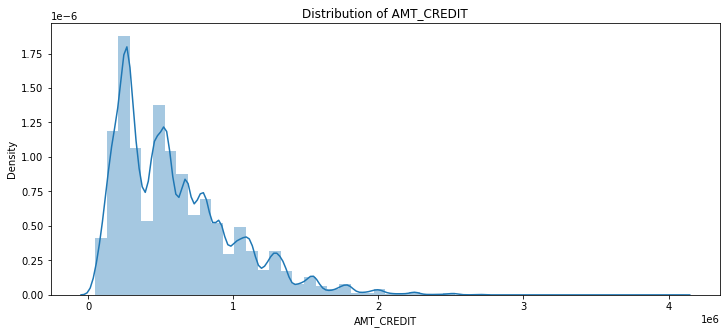

In [11]:
plt.figure(figsize=(12, 5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(application_train["AMT_CREDIT"])

## La raison du prêt

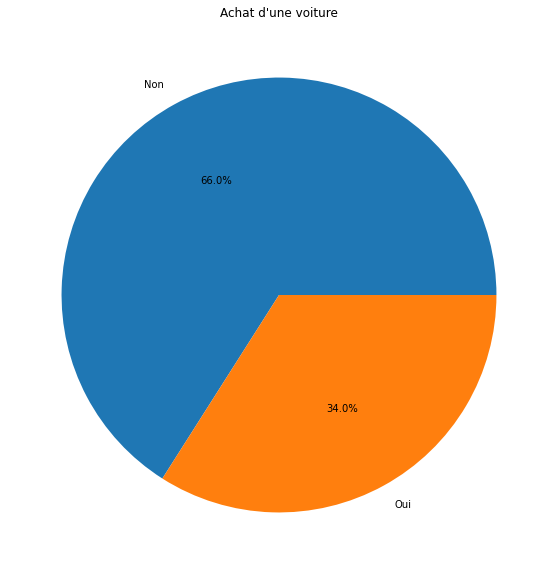

In [12]:
pie_loan = application_train["FLAG_OWN_CAR"].value_counts(
)/len(application_train)*100

fig = plt.figure(figsize=(18, 10))
plt.pie(pie_loan,
        autopct='%1.1f%%',
        labels=["Non", "Oui"]
        )
plt.title("Achat d'une voiture")
plt.show()

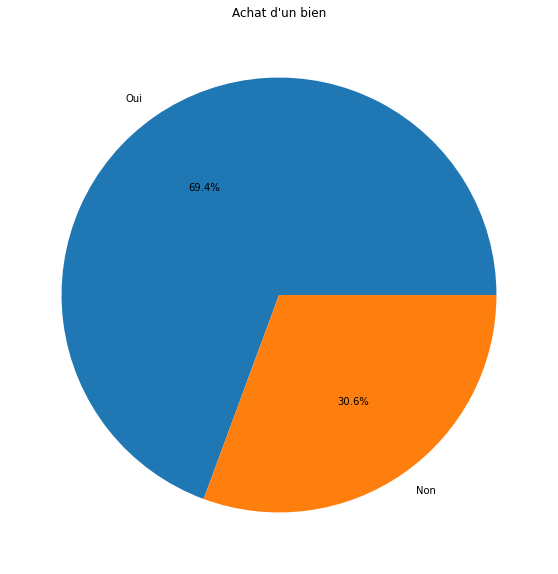

In [13]:
pie_loan_maison = application_train["FLAG_OWN_REALTY"].value_counts(
)/len(application_train)*100

fig = plt.figure(figsize=(18, 10))
plt.pie(pie_loan_maison,
        autopct='%1.1f%%',
        labels=["Oui", "Non"])
plt.title("Achat d'un bien")
plt.show()

## L'accompagnement du client lors de la demande de pret

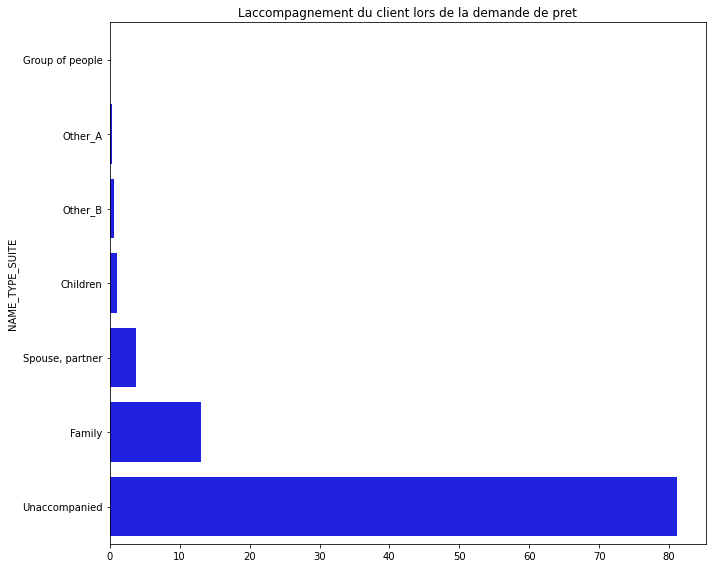

In [14]:
accompagnemment = application_train.groupby(
    'NAME_TYPE_SUITE').size().sort_values()

fig = plt.figure(figsize=(10, 8))
sns.barplot(y=accompagnemment.index, x=(accompagnemment.values / accompagnemment.sum())*100,
            color='blue')
plt.title('Laccompagnement du client lors de la demande de pret')
plt.tight_layout()

## Sources des revenus des demendeurs

In [15]:
temp = application_train["NAME_INCOME_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                   })
df.iplot(kind='pie', labels='labels', values='values',
         title='Sources des revenus des demendeurs', hole=0.5)

51.6 % Applicants mentioned that they are working. 23.3 % are Commercial Associate and 18 % are Pensioner etc.

## Le metier des demendeurs de prêt

In [16]:
temp = application_train["OCCUPATION_TYPE"].value_counts()
temp.iplot(kind='bar', xTitle='Occupation',
           yTitle="Count",
           title='Le metier des demendeurs de prêt',
           color='green')

In [17]:
temp = application_train["NAME_INCOME_TYPE"].value_counts()
# print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(
        application_train["TARGET"][application_train["NAME_INCOME_TYPE"] == val] == 1))
    temp_y0.append(np.sum(
        application_train["TARGET"][application_train["NAME_INCOME_TYPE"] == val] == 0))
trace1 = go.Bar(
    x=temp.index,
    y=(temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x=temp.index,
    y=(temp_y0 / temp.sum()) * 100,
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title="Les sources de revenus du demandeur en termes de prêt sont remboursées ou non en %",
    # barmode='stack',
    width=1000,
    xaxis=dict(
        title='Income source',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [18]:
temp = application_train["OCCUPATION_TYPE"].value_counts()
# print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(
        application_train["TARGET"][application_train["OCCUPATION_TYPE"] == val] == 1))
    temp_y0.append(np.sum(
        application_train["TARGET"][application_train["OCCUPATION_TYPE"] == val] == 0))
trace1 = go.Bar(
    x=temp.index,
    y=(temp_y1 / temp.sum()),
    name='YES'
)
trace2 = go.Bar(
    x=temp.index,
    y=(temp_y0 / temp.sum()),
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title="Les activités pro du demandeur en termes de prêt sont remboursées ou non en %",
    # barmode='stack',
    width=1000,
    xaxis=dict(
        title='Income source',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Normaliser

# Analyse de la colonne TARGET

C'est l'objectif de l'étude et ce que l'on nous demande de prédire 

+ 0 signifie que le prêt a été remboursé à temps
+ 1 signifie que le client a eu des difficultés de remboursement

In [19]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

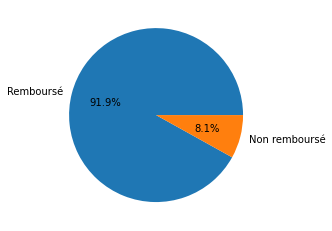

In [20]:
pie_target_train = application_train['TARGET'].value_counts(
)/len(application_train)*100

# plot pie
plt.pie(pie_target_train,
        autopct='%1.1f%%',
        labels=["Remboursé", "Non remboursé"]
        )
plt.show()

D'après ces informations, nous constatons qu'il s'agit d'un problème de classes déséquilibrées. Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés. Lorsque nous utiliserons des modèles d'apprentissage automatique plus sophistiqués, nous pourrons pondérer les classes en fonction de leur représentation dans les données afin de refléter ce déséquilibre.

# Valeures manquantes / les types de colonnes 

In [21]:
information(application_train)

307511 lignes et 122 colonnes
************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
Informations sur les features :  None
************************************************************
Le nombre total de valeur manquante : 
 SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STAT

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,...,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


En premier lieu nous allons regarder les valeurs manquantes de notre dataset 
 + Nous pouvons voir que certaine colonnes ont des valeurs manquantes assez importantes 

Concernant les types de colonnes :
   + Nous avons 106 variables numériques (float64 + int64) et 16 variables de chaines de caractères (objects), nous allons les regarder plus en détail

In [22]:
application_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques.
Nous devrons trouver un moyen de traiter ces variables catégorielles.

# Encodage des variables catégorielles

Avant d'aller plus loin, nous devons nous occuper de ces variables catégorielles.
Un modèle d'apprentissage automatique ne peut malheureusement pas
traiter les variables catégorielles (à l'exception de certains
modèles tels que LightGBM). Par conséquent, nous devons trouver
un moyen de coder (représenter) ces variables sous forme de nombres
avant de les transmettre au modèle.
Il existe deux façons principales d'effectuer ce processus :

+ Label encoding : attribuer un nombre entier à chaque catégorie unique d'une variable catégorielle. Aucune nouvelle colonne n'est créée. Un exemple est présenté ci-dessous

+ One-hot encoding : créer une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne pour sa catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

Le problème de label encoding est qu'il donne aux catégories
un ordre arbitraire. La valeur attribuée à chacune des catégories
est aléatoire et ne reflète aucun aspect inhérent à la catégorie.
Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le spécialiste
des données un 1, mais si nous refaisions le même processus,
les étiquettes pourraient être inversées ou complètement différentes.
L'affectation réelle des entiers est arbitraire.
Par conséquent, lorsque nous effectuons le label encoding, le modèle
peut utiliser la valeur relative de la caractéristique (par exemple,
programmeur = 4 et scientifique = 1) pour attribuer des poids,
ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs
uniques pour une variable catégorielle (telle que Male/Femelle),
l'encodage label encoding est parfait, mais pour plus de deux
catégories uniques, l'encodage One Hot Encoder est l'option la plus sûre.

Les mérites relatifs de ces approches font l'objet d'un débat,
et certains modèles peuvent traiter des variables catégorielles
codées par étiquette sans problème. Je pense que pour les variables
catégorielles avec de nombreuses classes, l'encodage One Hot Encoder
est l'approche la plus sûre car elle n'impose pas de valeurs arbitraires
aux catégories. Le seul inconvénient de l'encodage one-hot est que le nombre
de caractéristiques (dimensions des données) peut exploser
avec des variables catégorielles comportant de nombreuses catégories.
Pour y remédier, nous pouvons effectuer un codage One-Hot
suivi d'une ACP ou d'autres méthodes de réduction de la dimensionnalité
pour réduire le nombre de dimensions (tout en essayant de préserver l'information).

Dans ce notebook, nous utiliserons l'encodage label encoding
pour toutes les variables catégorielles avec seulement 2 catégories
et l'encodage One Hot Encoder pour toutes les variables
catégorielles avec plus de 2 catégories.
Ce processus peut être modifié à mesure que nous avançons dans
le projet, mais pour l'instant, nous allons voir où cela nous mène.

## Label Encoding and One-Hot Encoding

Mettons en œuvre la politique décrite ci-dessus : pour toute variable
catégorielle (dtype == object) avec 2 catégories uniques, nous
utiliserons Label Encoding, et pour toute variable catégorielle
avec plus de 2 catégories uniques, nous utiliserons One-Hot Encoding.

Pour Label Encoding, nous utilisons le LabelEncoder de Scikit-Learn
et pour One-Hot Encoding, la fonction pandas get_dummies(df).

## Gestion des valeurs manquantes/aberrantes

Les valeurs aberrantes dans les données sont un problème auquel
nous devons toujours être attentifs lorsque nous faisons de l'AED.
Celles-ci peuvent être dues à des chiffres mal saisis, à des erreurs
dans l'équipement de mesure ou à des mesures valides mais extrêmes.
Une façon d'étayer les valeurs aberrantes de manière quantitative
est d'examiner les statistiques d'une colonne en utilisant
la méthode de description.
Les chiffres de la colonne DAYS_BIRTH sont négatifs car ils
sont enregistrés par rapport à la demande de prêt en cours.

Pour voir ces statistiques en années, nous pouvons les
multiplier par -1 et les diviser par le nombre de jours dans une année :

#### L'age des demendeurs

In [23]:
app_train = application_train.copy()

In [24]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables.
Il n'y a pas de valeurs aberrantes pour l'âge,
ni en haut ni en bas.

#### Le nombre de jours depuis la date de début d'emploi

In [25]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Cela ne semble pas correct !
La valeur maximale (en plus d'être positive)
est d'environ 1000 ans !

Text(0.5, 0, 'Days Employment')

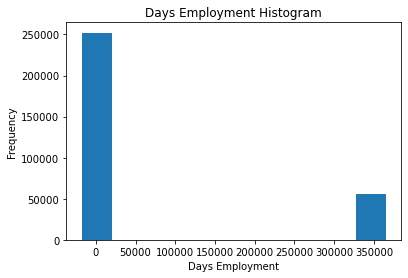

In [26]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

Juste par curiosité, sous-ensemblons les clients anormaux
et voyons s'ils ont tendance à avoir des taux de défaillance
plus élevés ou plus faibles que le reste des clients:

In [27]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' %
      (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' %
      (100 * anom['TARGET'].mean()))
print('Il y a %d jours de travail anormaux' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
Il y a 55374 jours de travail anormaux


C'est extrêmement intéressant !
Il s'avère que les anomalies ont un taux de défaillance plus faible.

Le traitement des anomalies dépend de la situation exacte,
et il n'existe pas de règles fixes. L'une des approches
les plus sûres consiste à définir les anomalies comme
des valeurs manquantes, puis à les compléter (en utilisant
l'imputation) avant l'apprentissage automatique.

Dans ce cas, puisque toutes les anomalies ont exactement
la même valeur, nous voulons les compléter avec la même
valeur au cas où tous ces prêts ont quelque chose en commun.
Les valeurs anormales semblent avoir une certaine importance,
nous voulons donc indiquer au modèle d'apprentissage automatique
si nous avons effectivement rempli ces valeurs.
Comme solution, nous allons remplir les valeurs anormales
avec un nombre nul (np.nan) et ensuite créer une nouvelle
colonne booléenne indiquant si la valeur était anormale ou non.

Text(0.5, 0, 'Days Employment')

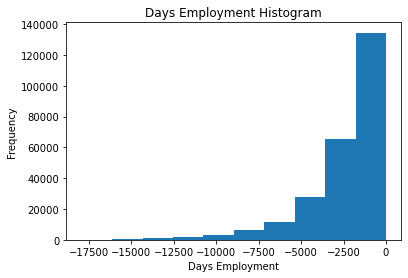

In [28]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

La distribution semble beaucoup plus conforme à ce que nous attendions,
et nous avons également créé une nouvelle colonne pour indiquer au modèle
que ces valeurs étaient à l'origine anormales (car nous devrons remplir
les nans avec une valeur quelconque, probablement la médiane de la colonne).
Les autres colonnes contenant des jours dans la trame de données semblent
correspondre à ce que nous attendons, sans valeurs aberrantes évidentes.



# Etude des Corrélations

Maintenant que nous avons traité les variables catégorielles
et les valeurs aberrantes, poursuivons avec l'AED. Une façon
d'essayer de comprendre les données est de rechercher des
corrélations entre les caractéristiques et la cible.
Nous pouvons calculer le coefficient de corrélation de Pearson
entre chaque variable et la cible en utilisant la méthode .corr
applicable aux dataframes de Pandas.

Le coefficient de corrélation n'est pas la meilleure méthode
pour représenter la "pertinence" d'une caractéristique,
mais il nous donne une idée des relations possibles au sein
des données.

Voici quelques interprétations générales
de la valeur absolue du coefficient de corrélation :

+ 0,00-0,19 "très faible"
+ 0,20 à 0,39 "faible"
+ 0,40-0,59 "modéré"
+ 0,60-0,79 "forte"
+ 0,80-1,0 "très forte"

## Corrélation de toutes les variables entre-elles

In [29]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


Regardons certaines des corrélations les plus significatives :
La corrélation DAYS_BIRTH est la plus positive. (sauf pour TARGET car
la corrélation d'une variable avec elle-même est toujours de 1 !)
En regardant la documentation, DAYS_BIRTH est l'âge en jours du client
au moment du prêt en jours négatifs.
La corrélation est positive, mais la valeur de cette caractéristique
est en fait négative, ce qui signifie que plus le client vieillit,
moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire
que la cible == 0). C'est un peu déroutant, nous allons donc prendre
la valeur absolue de la caractéristique et la corrélation sera alors négative.

## Effet de l'âge sur le remboursement des prêts

In [30]:
# Trouvez la corrélation des jours positifs depuis la naissance et la target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

Au fur et à mesure que le client vieillit, il existe une relation
linéaire négative avec la target, ce qui signifie que plus les
clients vieillissent, plus ils ont tendance à rembourser leurs prêts dans les délais.

Commençons à examiner cette variable.
Tout d'abord, nous pouvons faire un histogramme de l'âge.
Nous allons mettre l'axe des x en années
pour rendre le graphique un peu plus compréhensible.

Text(0, 0.5, 'Count')

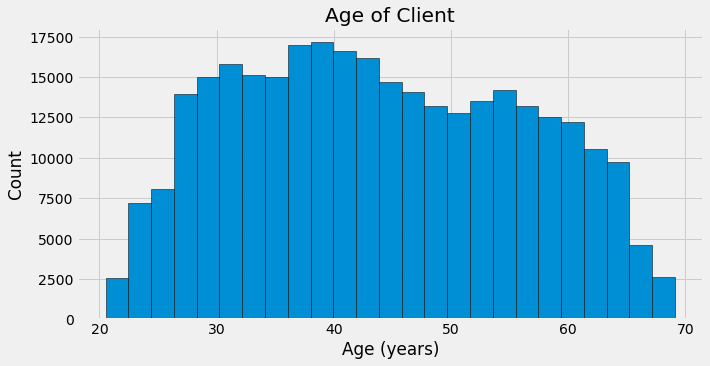

In [31]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.figure(figsize=(10, 5))
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

En soi, la distribution de l'âge ne nous apprend pas grand-chose,
si ce n'est qu'il n'y a pas de valeurs aberrantes puisque
tous les âges sont raisonnables.
Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite
réaliser un graphique d'estimation de la densité du noyau (KDE)
coloré par la valeur de la cible.
Un graphique d'estimation de la densité du noyau montre la
distribution d'une seule variable et peut être considéré
comme un histogramme lissé.
Nous utiliserons le kdeplot de Seaborn pour ce graphique.

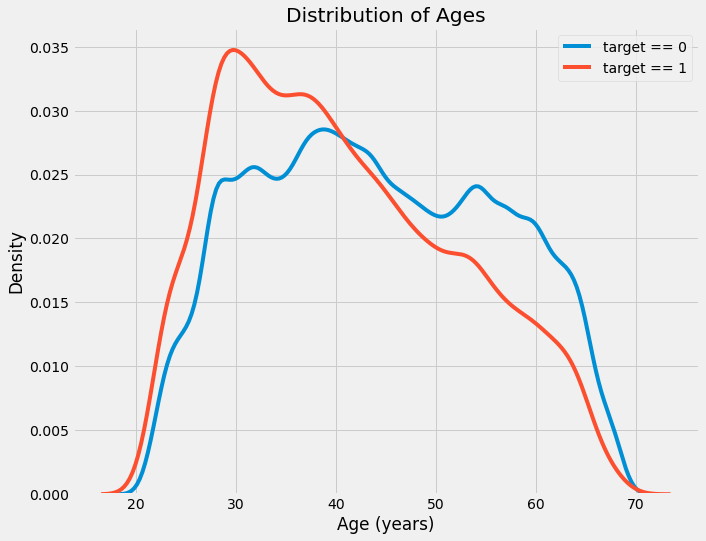

In [32]:
plt.figure(figsize=(10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0,
            'DAYS_BIRTH'] / 365, label='target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1,
            'DAYS_BIRTH'] / 365, label='target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

plt.legend()
plt.show()

La courbe de la cible == 1 penche vers l'extrémité la plus jeune de la fourchette.
Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient
de corrélation de -0,07), cette variable sera probablement utile
dans un modèle d'apprentissage automatique car elle affecte la cible.
Examinons cette relation d'une autre manière : l'échec moyen du
remboursement des prêts par tranche d'âge.

Pour réaliser ce graphique, nous découpons d'abord la catégorie d'âge
en tranches de 5 ans chacune. Ensuite, pour chaque bac, nous calculons
la valeur moyenne de la cible, qui nous indique le ratio de prêts
non remboursés dans chaque catégorie d'âge.

In [33]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(
    age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [34]:
# Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, "Défaut de remboursement par tranche d'âge")

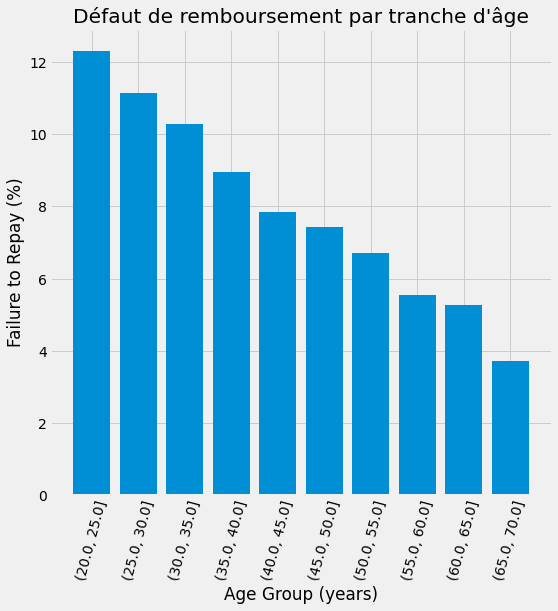

In [35]:
plt.figure(figsize=(8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title("Défaut de remboursement par tranche d'âge")

La tendance est claire : les jeunes demandeurs sont plus susceptibles
de ne pas rembourser le prêt ! Le taux de non-remboursement est
supérieur à 10 % pour les trois groupes d'âge les plus jeunes
et inférieur à 5 % pour le groupe le plus âgé.

Il s'agit d'une information qui pourrait être utilisée directement
par la banque : puisque les clients les plus jeunes sont moins
susceptibles de rembourser le prêt, il faudrait peut-être leur
fournir davantage de conseils ou d'astuces de planification financière.
Cela ne signifie pas que la banque doive faire preuve de discrimination
à l'égard des jeunes clients, mais il serait judicieux de prendre
des mesures de précaution pour aider les jeunes clients à rembourser dans les délais.

### Sources extérieures

Les 3 variables présentant les corrélations négatives les plus
fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3.
Selon la documentation, ces caractéristiques représentent un "score
normalisé provenant d'une source de données externe".
Je ne suis pas sûr de ce que cela signifie exactement,
mais il peut s'agir d'une sorte de notation cumulative
réalisée à partir de nombreuses sources de données.

Jetons un coup d'œil à ces variables:

Tout d'abord, nous pouvons montrer les corrélations des
caractéristiques EXT_SOURCE avec la cible et entre elles.

In [36]:
# Extraire les variables EXT_SOURCE et afficher les corrélations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1',
                      'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

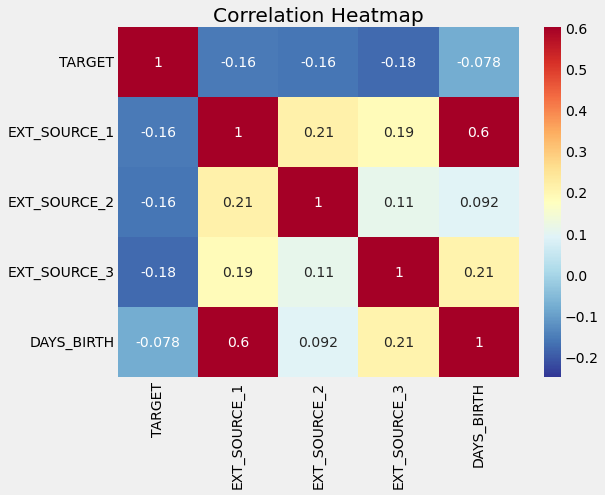

In [37]:
plt.figure(figsize=(8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r,
            vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives
avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE
augmente, plus le client est susceptible de rembourser le prêt.
Nous pouvons également voir que DAYS_BIRTH est positivement corrélé
avec EXT_SOURCE_1, ce qui indique que l'un des facteurs de ce score
est peut-être l'âge du client.

Ensuite, nous pouvons examiner la distribution de chacune de
ces caractéristiques colorées par la valeur de la cible.
Cela nous permettra de visualiser l'effet de cette variable sur la cible.



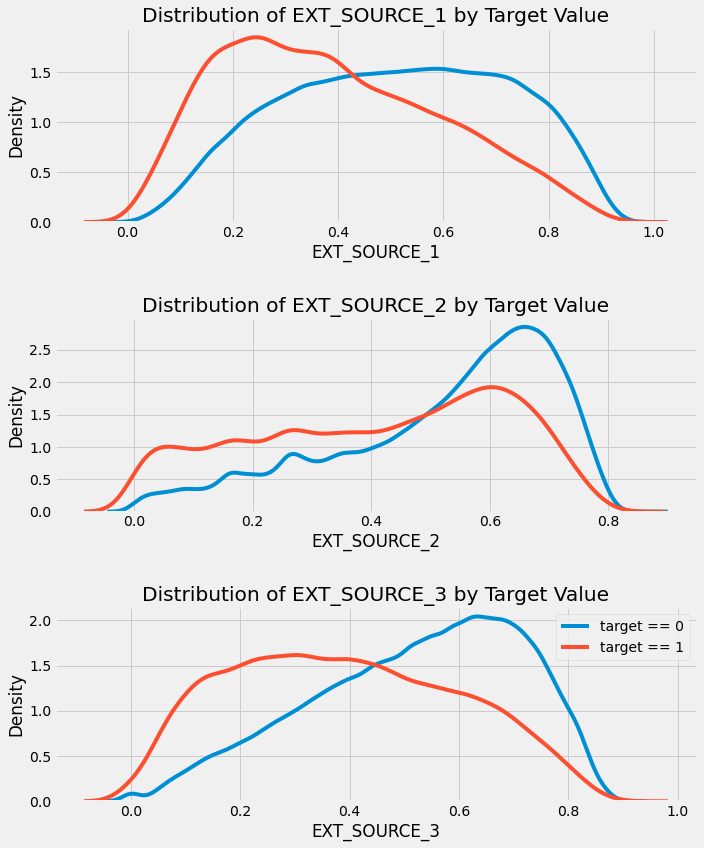

In [38]:
plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET']
                == 0, source], label='target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET']
                == 1, source], label='target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')

plt.legend()
plt.tight_layout(h_pad=2.5)


Represente la situation financiere du client, plus le client a de l'ext source moins il a tendance à moins rembourser 

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible.
Nous pouvons clairement voir que cette caractéristique a une certaine relation
avec la probabilité qu'un demandeur rembourse un prêt.
La relation n'est pas très forte (en fait, elles sont toutes considérées
comme très faibles), mais ces variables seront toujours utiles pour un modèle
d'apprentissage automatique permettant de prédire si un demandeur
remboursera ou non un prêt à temps.

## Pairs Plot

Comme dernier graphique exploratoire, nous pouvons réaliser un graphique
en paires des variables EXT_SOURCE et de la variable DAYS_BIRTH.
Le graphique en paires est un excellent outil d'exploration car
il nous permet de voir les relations entre plusieurs paires de
variables ainsi que les distributions de variables uniques.
Ici, nous utilisons la bibliothèque de visualisation seaborn
et la fonction PairGrid pour créer un Pairs Plot avec des nuages
de points sur le triangle supérieur, des histogrammes sur la diagonale,
et des diagrammes de densité de noyau 2D et des coefficients
de corrélation sur le triangle inférieur.

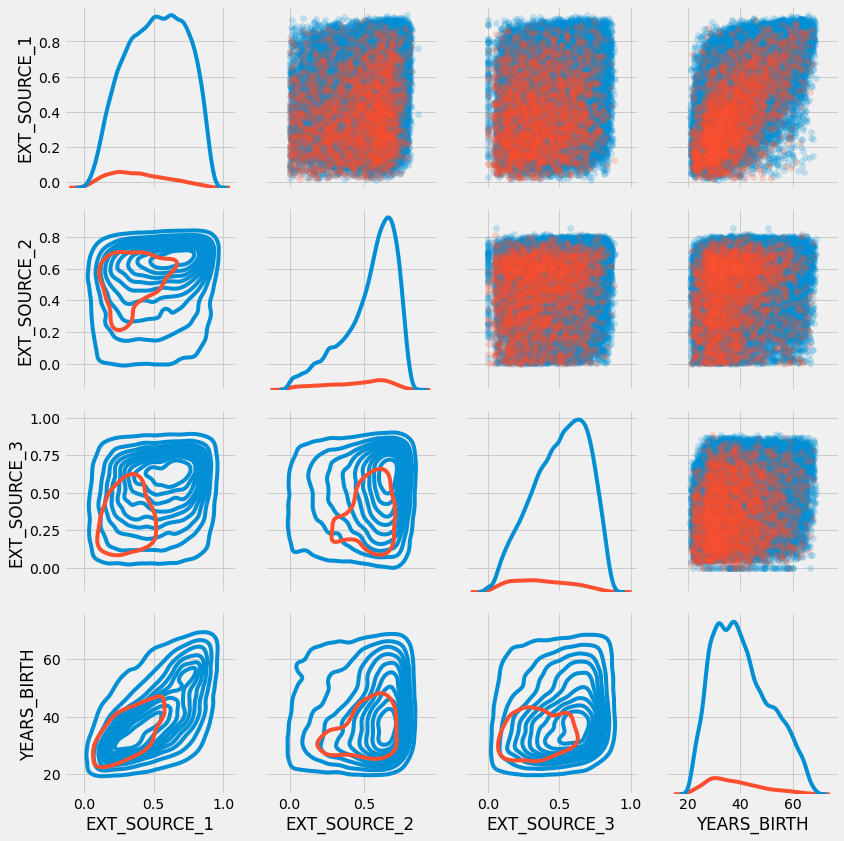

In [39]:
# Copy the data for plotting
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns


def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size=20)


# Create the pairgrid object
grid = sns.PairGrid(data=plot_data, size=3, diag_sharey=False,
                    hue='TARGET',
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha=0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

Dans ce graphique, le rouge indique les prêts qui n'ont pas été remboursés
et le bleu les prêts qui sont payés. Nous pouvons voir les différentes
relations au sein des données. Il semble y avoir une relation linéaire
positive modérée entre l'EXT_SOURCE_1 et le DAYS_BIRTH (ou équivalent YEARS_BIRTH),
ce qui indique que cette caractéristique peut prendre en compte l'âge du client.

# Feature Engineering

Les concours Kaggle sont remportés par la maitrise du
Feature Engineering (l'ingénierie des caractéristiques) :
les gagnants sont ceux qui peuvent créer les caractéristiques
les plus utiles à partir des données.
Cela représente l'une des tendances de l'apprentissage automatique :
l'ingénierie des caractéristiques a un meilleur retour
sur investissement que la construction de modèles et
le réglage des hyperparamètres.

Bien que le choix du bon modèle et des paramètres optimaux soient importants, le modèle ne peut apprendre que des données qui lui sont fournies. S'assurer que ces données sont aussi pertinentes que possible pour la tâche est le travail du scientifique des données

Les feature engineering fait référence à un processus général et peut impliquer à la fois 
+ la construction des caractéristiques : ajouter des nouvelles caractéristiques à partir des données existantes 
+ la séletion des caractéristiques : choisir uniquement les caractéristiques les plus importantes ou d'autres méthodes de réduction de la dimensionnalité. 
Il existe de nombreuses techniques que nous pouvons utiliser à la fois pour créer des fonctionnalités et sélectionner des fonctionnalités.

#### Polynomial Features

Une méthode simple de construction de caractéristiques est appelée polynomial features. Dans cette méthode, nous créons des fonctionnalités qui sont des puissances de fonctionnalités existantes ainsi que des termes d'interaction entre des fonctionnalités existantes. Par exemple, nous pouvons créer des variables EXT_SOURCE_1^2 et EXT_SOURCE_2^2 et aussi des variables comme EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2. Ces caractéristiques qui sont une combinaison de plusieurs variables individuelles sont appelées termes d'interaction car elles capturent les interactions entre les variables. En d'autres termes, alors que deux variables en elles-memes peuvent ne pas avoir une forte influence sur la cible, leur combinaison en une seule variable d'interaction peut montrer une relation avec la cible. Les termes d'interaction sont couramment utilisés dans les modèles statistiques pour capturer les effets de plusieurs variables. Néanmoins, nous pouvons en essayer quelques-uns pour voir s'ils peuvent aider notre modèle à prédire si un client remboursera ou non un prêt.

Dans le code suivant, nous créons des entités polynomiales en utilisant les variables EXT_SOURCE et la variable DAYS_BIRTH. Scikit-Learn a une classe utile appelée polynomialFeatures qui crée les polynômes et les termes d'interaction jusqu'a un degré spécifique. Nous pouvons utiliser un degré de 3 pour voir les résultats(lorsque nous créons des caractéristiques polynomiales, nous voulons éviter d'utiliser un degré trop élevé, à la fois parce que le nombre de caractéristiques évolue de façon exponentielle avec le degré, et parce que nous pouvons rencontrer des problèmes avec le surapprentissage

In [40]:
# Make a new dataframe for polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2',
                           'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]


# imputer for handling missing values
imputer = SimpleImputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=3)

In [41]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


Cela crée un nombre considérable de nouvelles fonctionnalités. Pour obtenir les noms, nous devons utiliser la méthode get_feature_names des entités polynomiales.

In [42]:
poly_transformer.get_feature_names(
    input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

Il y a 35 fonctionnalités avec des fonctionnalités individuelles élevées à des puissances allant jusqu'au degré 3 et des termes d'interaction. Maintenant, nous pouvons voir si l'une de ces nouvelles fonctionnalités est corrélée à la cible.

In [43]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                             columns=poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                         'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Plusieurs des nouvelles variables ont une plus grande corrélation (en termes d'amplitude absolue) avec la cible que les caractéristiques d'origine. Lorsque nous créons des modèles d'apprentissage automatique, nous pouvons essayer avec et sans ces fonctionnalités pour déterminer si elles aident réellement le modèle à apprendre.


Nous ajouterons ces fonctionnalités à une copie des données d'entraînement et de test, puis évaluerons les modèles avec et sans les fonctionnalités. Souvent, en apprentissage automatique, la seule façon de savoir si une approche fonctionnera est de l'essayer !

In [44]:
poly_features = poly_features.drop(columns=['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                           'EXT_SOURCE_3','DAYS_BIRTH','TARGET','1'])

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)


Training data with polynomial features shape:  (307511, 153)


## Deuxième dataset avec création de nouvelles variables 

Il n'est peut-être pas tout à fait correct d'appeler cela « connaissance du domaine » parce que je ne suis pas un expert en crédit, mais peut-être pourrions-nous appeler cela « tentatives d'appliquer des connaissances financières limitées ». Dans cet état d'esprit, nous pouvons créer quelques fonctionnalités qui tentent de capturer ce que nous pensons être important pour dire si un client fera défaut sur un prêt. Ici, je vais utiliser cinq fonctionnalités qui ont été inspirées par ce script d'Aguiar :

+ YEARS_EMPLOYED : Nombre d'années travaillés
+ YEARS_BIRTH : Age en année
+ YEARS_BINNED : Tranche d'age 
+ CREDIT_INCOME_PERCENT: Le pourcentage du montant du crédit par rapport aux revenus d'un client 
+ ANNUITY_INCOME_PERCENT: le pourcentage de la rente du prêt par rapport au revenu d'un client
+ CREDIT_TERM: La durée du versement en mois (puisque la rente est le montant mensuel dû)
+ DAYS_EMPLOYED_PERCENT: le pourcentage des jours de travail par rapport à l'âge du client

Encore une fois, merci à Aguiar et son excellent script pour explorer ces fonctionnalités

In [45]:
app_train_domain = app_train.copy()

app_train_domain['YEARS_EMPLOYED'] = -app_train_domain["DAYS_EMPLOYED"]/365
app_train_domain['YEARS_BIRTH'] = app_train_domain['DAYS_BIRTH'] / 365
app_train_domain['YEARS_BINNED'] = pd.cut(
    app_train_domain['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / \
    app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / \
    app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / \
    app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / \
    app_train_domain['DAYS_BIRTH']

app_train_domain.drop([ "DAYS_EMPLOYED", "DAYS_BIRTH"], axis=1, inplace=True)

### Visualize New Variables

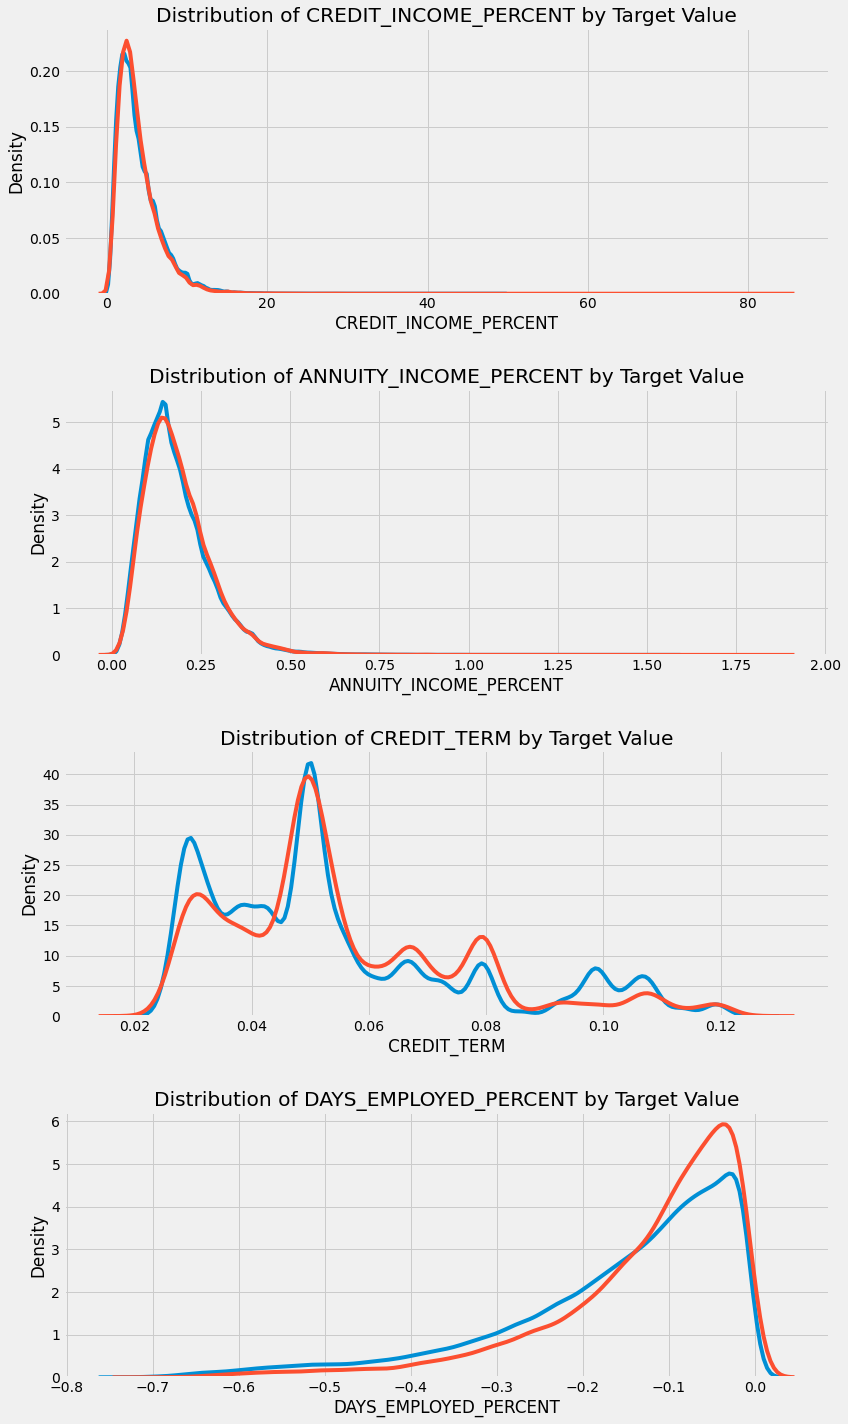

In [46]:
plt.figure(figsize=(12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(
        app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label='target == 0')
    # plot loans that were not repaid
    sns.kdeplot(
        app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label='target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')

plt.tight_layout(h_pad=2.5)

## Exportation de nos jeux de données 

In [ ]:
app_train_poly.to_csv(
    '/Users/vincentMalfroy/Desktop/OpenClassrooms/Projet 7/credit-default-risk/X_poly.csv',
    index=True)

In [ ]:
app_train_domain.to_csv(
    '/Users/vincentMalfroy/Desktop/OpenClassrooms/Projet 7/credit-default-risk/X_features.csv',
    index=True)

Nous allons regrouper certaines cellules en fonction et modifier certaines pour que cela corresponde à notre mission

# Création pour le dashboard

Dataset sans la target avec les informations socio-demographiques sur les clients 

In [50]:
app_dash = app_train_domain.drop(columns=['TARGET'])

In [51]:
app_dash.to_csv(
    '/Users/vincentMalfroy/Desktop/OpenClassrooms/Projet 7/credit-default-risk/X_dash.csv',
    index=True)

## Information clients 

In [ ]:
df_information = application_train[["SK_ID_CURR","CODE_GENDER", "DAYS_BIRTH",
                                   "AMT_INCOME_TOTAL","DAYS_EMPLOYED",'NAME_EDUCATION_TYPE' ]]

In [ ]:
# Création de variables info clients : âge en années, ressources,durée emploi en années, genre : M ou F
df_information["GENDER"] = df_information["CODE_GENDER"].replace({0 : "Male", 1 : "Female"})
df_information['YEARS_BIRTH'] = -df_information["DAYS_BIRTH"]/365
df_information['YEARS_EMPLOYED'] = -df_information["DAYS_EMPLOYED"]/365
df_information.drop([ "DAYS_EMPLOYED", "DAYS_BIRTH", "CODE_GENDER"], axis=1, inplace=True)

In [ ]:
df_information.head(100)

In [ ]:
df_information = df_information.set_index('SK_ID_CURR')

## Création pour la prédiction du prêt

In [ ]:
final = pd.merge(left=df_results_clf, right=test, 
                         left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [ ]:
final

### Rassemblement des deux datasets

In [ ]:
df_final = pd.merge(left=df_information, right=final, 
                         left_on='SK_ID_CURR', right_on='SK_ID_CURR')

# Reset index
df_final = df_final.reset_index()

In [ ]:
df_final